In [ ]:
# !pip install tkiner

#%%
# Export PATH
import sys
sys.path.append("..")
# 
from models.gwfastWrapClass import gwfast_class
from src.samplers import samplers
from scripts.plot_helper_functions import collect_samples
import numpy as np
import logging
import sys
from collections import OrderedDict
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
import os
import time
import copy
import time
import gwfast.gwfastUtils as utils
import gwfast.gwfastGlobals as glob
import gwfast.signal as signal
from gwfast.network import DetNet
from gwfast.waveforms import TaylorF2_RestrictedPN, IMRPhenomD
from astropy.cosmology import Planck18
import matplotlib.pyplot as plt
from numdifftools import Jacobian, Gradient, Hessdiag
from jax import jacobian
from corner import corner
import jax

In [2]:
!pip install git+https://github.com/CosmoStatGW/gwfast
!pip install pyinstrument
!pip install corner
!pip install tk

  Cloning https://github.com/CosmoStatGW/gwfast to /tmp/pip-req-build-adq018rs
  Running command git clone --filter=blob:none --quiet https://github.com/CosmoStatGW/gwfast /tmp/pip-req-build-adq018rs
  Resolved https://github.com/CosmoStatGW/gwfast to commit b0afccdbe1239509e27128620119d18c40e02fe9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 52.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 28.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 742.9/742.9 kB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 48.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.9 MB/s e

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.0/112.0 kB 23.2 MB/s eta 0:00:00


In [8]:
!git stash
!git pull

Saved working directory and index state WIP on geodesic_kernels: 5ec495c backup for colab
Updating 5ec495c..96d375d
Updating files: 100% (6/6), done.
Fast-forward
 models/double_banana.py                |   1 +
 models/gwfastWrapClass.py              |  86 ++++++++++++++++++++++++---------
 notebooks/double_banana_flows.ipynb    |  21 ++++++--
 notebooks/gwfast_driver.py             |  49 +++++++++++++------
 notebooks/marginals/cross_sections.zip | Bin 0 -> 595655 bytes
 src/samplers.py                        |  85 ++++++++++++++++----------------
 6 files changed, 158 insertions(+), 84 deletions(-)
 create mode 100644 notebooks/marginals/cross_sections.zip


In [ ]:
##########################
####### (GW150914) #######
##########################
tGPS = np.array([1.12625946e+09])
injParams = dict()
# injParams['tcoal'] = utils.GPSt_to_LMST(tGPS, lat=0., long=0.) # Coalescence time, in units of fraction of day (GMST is LMST computed at long = 0°) 
injParams['tcoal']   = np.array([0.]) # Coalescence time, in units of fraction of day (GMST is LMST computed at long = 0°) 
injParams['Mc']      = np.array([34.3089283])        # Units: M_sun
injParams['eta']     = np.array([0.2485773])         # Units: Unitless
injParams['dL']      = np.array([0.43929891 * 6])        # Units: Gigaparsecs 
injParams['theta']   = np.array([2.78560281])        # Units: Rad
injParams['phi']     = np.array([1.67687425])        # Units: Rad
injParams['iota']    = np.array([2.67548653])        # Units: Rad
injParams['psi']     = np.array([0.78539816])        # Units: Rad
injParams['Phicoal'] = np.array([0.])                # Units: Rad
injParams['chiS']    = np.array([0.27210419])        # Units: Unitless
injParams['chiA']    = np.array([0.33355909])        # Units: Unitless

#  Setup gravitational wave network problem

all_detectors = copy.deepcopy(glob.detectors) # Geometry of every available detector

# LV_detectors = {det:all_detectors[det] for det in ['L1', 'H1', 'Virgo']} # Extract only LIGO/Virgo detectors
LV_detectors = {det:all_detectors[det] for det in ['L1', 'H1']}

print('Using detectors ' + str(list(LV_detectors.keys())))

detector_ASD = dict() # Remark: Providing ASD path to psd_path with flag "is_ASD = True" in
detector_ASD['L1']    = 'O3-L1-C01_CLEAN_SUB60HZ-1240573680.0_sensitivity_strain_asd.txt'
detector_ASD['H1']    = 'O3-H1-C01_CLEAN_SUB60HZ-1251752040.0_sensitivity_strain_asd.txt'
detector_ASD['Virgo'] = 'O3-V1_sensitivity_strain_asd.txt'

LV_detectors['L1']['psd_path']    = os.path.join(glob.detPath, 'LVC_O1O2O3', detector_ASD['L1']) # Add paths to detector sensitivities
LV_detectors['H1']['psd_path']    = os.path.join(glob.detPath, 'LVC_O1O2O3', detector_ASD['H1'])
# LV_detectors['Virgo']['psd_path'] = os.path.join(glob.detPath, 'LVC_O1O2O3', detector_ASD['Virgo'])

# waveform = TaylorF2_RestrictedPN() # Choice of waveform
waveform = IMRPhenomD()

fgrid_dict = {'fmin': 20, 'fmax': 325, 'df': 1./5} # All parameters related to frequency grid.

priorDict = OrderedDict()
# priorDict['Mc']      = [20., 50.]          # (1)
# priorDict['eta']     = [0.1, 0.25]        # (2)

priorDict['Mc']      = [29., 39.]          # (1)
priorDict['eta']     = [0.22, 0.25]        # (2)
priorDict['dL']      = [0.1, 3.]          # (3)
priorDict['theta']   = [0., np.pi]          # (4)
priorDict['phi']     = [0., 2*np.pi]          # (5)
priorDict['iota']    = [0., np.pi]        # (6)
priorDict['psi']     = [0., np.pi]            # (7)
priorDict['tcoal']   = [0., 1.]            # (8)
priorDict['Phicoal'] = [0., 1.]            # (9)
priorDict['chiS']    = [-1., 1.]         # (10)
priorDict['chiA']    = [-1., 1.]          # (11)

# priorDict['Mc']      = [32., 37.]          # (1)
# priorDict['eta']     = [0.24, 0.25]        # (2)
# priorDict['dL']      = [0.25, 2.]          # (3)
# priorDict['theta']   = [2.5, 2.9]          # (4)
# priorDict['phi']     = [1.2, 2.2]          # (5)
# priorDict['iota']    = [1.5, np.pi]        # (6)
# priorDict['psi']     = [0., 2.]            # (7)
# priorDict['tcoal']   = [0., 1.]            # (8)
# priorDict['Phicoal'] = [0., 1.]            # (9)
# priorDict['chiS']    = [0., 0.75]         # (10)
# priorDict['chiA']    = [0., 0.75]          # (11)

# Remark: Flag is chi1chi2=True. Parameter names will be transformed in gwfast to (chi1z, chi2z)

### Keep these constant ###
# priorDict['Mc']      = injParams['Mc']          # (1) 
# priorDict['eta']     = injParams['eta']         # (2)
# priorDict['dL']      = injParams['dL']          # (3)
# priorDict['theta']   = injParams['theta']       # (4)
# priorDict['phi']     = injParams['phi']         # (5)
# priorDict['iota']    = injParams['iota']        # (6)
# priorDict['psi']     = injParams['psi']         # (7)
priorDict['tcoal']   = injParams['tcoal']       # (8)
priorDict['Phicoal'] = injParams['Phicoal']     # (9)
# priorDict['chiS']    = injParams['chiS']        # (10)
# priorDict['chiA']    = injParams['chiA']        # (11)

nParticles = 500
model = gwfast_class(LV_detectors, waveform, injParams, priorDict, nParticles=nParticles, **fgrid_dict)
print('Using % i bins' % model.grid_resolution)

# Diagnostics

injParams_original = copy.deepcopy(injParams)
chi1z, chi2z = (injParams_original.pop('chiS'), injParams_original.pop('chiA'))
injParams_original['chi1z'] = chi1z
injParams_original['chi2z'] = chi2z
net = DetNet(model.detsInNet)
snr = net.SNR(injParams_original)
print('SNR is  ', snr)
H1_response = model.signal_data['L1']
power_spectral_density = model.strainGrid['L1']
fig, axs = plt.subplots(1, 2)
axs[0].plot(model.fgrid, H1_response)
axs[1].plot(model.fgrid, power_spectral_density)

In [ ]:
sampler1 = samplers(model=model, nIterations=200, nParticles=nParticles, profile=False)
sampler1.apply(method='sSVN', eps=0.1, h=2*model.DoF)

In [9]:
!pip install ChainConsumer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ChainConsumer: filename=ChainConsumer-0.34.0-py3-none-any.whl size=42758 sha256=a2713ba3784a4c5855679fa8796eaadaf1daca229bde1e3588486460c3553718
  Stored in directory: /root/.cache/pip/wheels/c4/a6/4e/3b70c1ab3dbfddf55db5abf6702eae7dbd1a3c20770d5b234c
Successfully built ChainConsumer


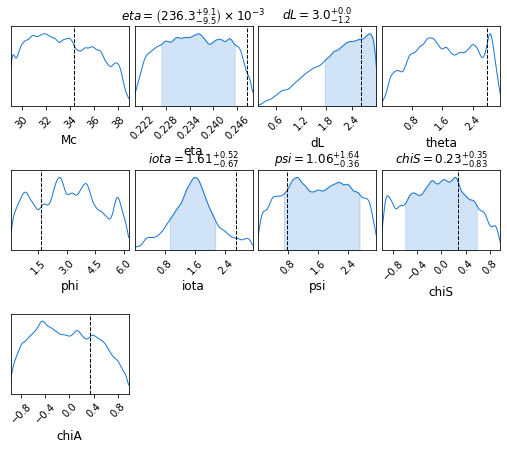

In [14]:
X1 = collect_samples(sampler1.history_path)
from chainconsumer import ChainConsumer
c = ChainConsumer().add_chain(X1, parameters=model.names_active)
summary = c.analysis.get_summary()
fig = c.plotter.plot_distributions(truth=model.true_params)


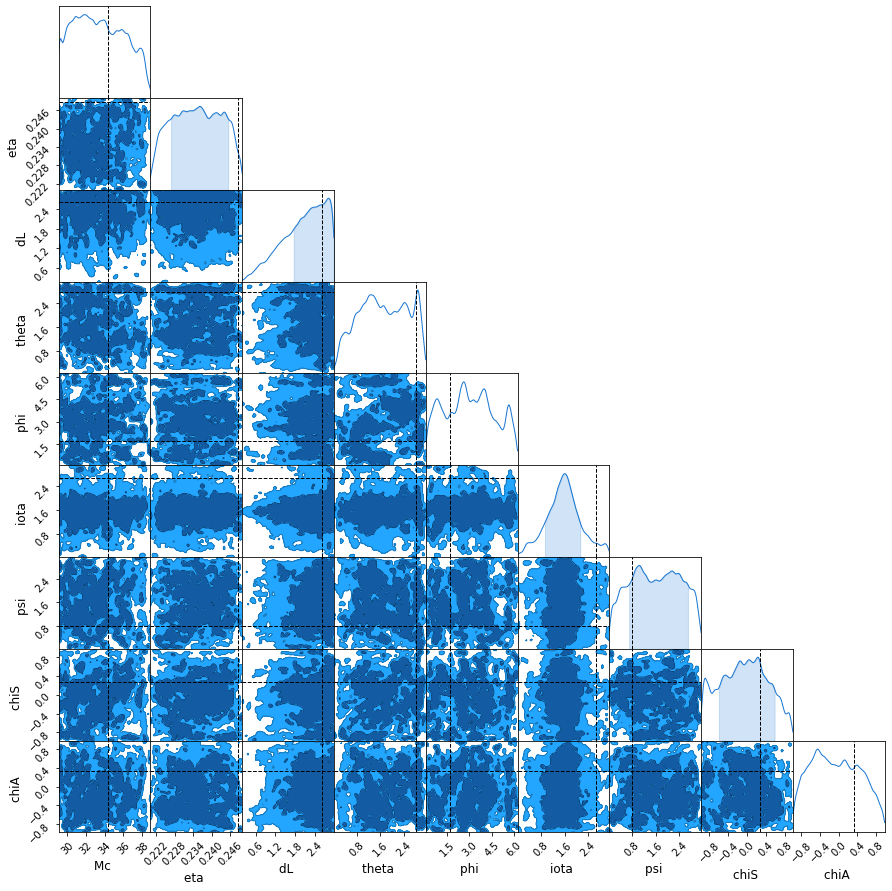

In [19]:
f = c.plotter.plot(filename="example.png", truth=model.true_params)

In [17]:
f.savefig('cornerplot.png')

In [18]:
os.getcwd()

'/notebooks/notebooks'